In [ ]:
# Local Imports
import preprocess
# Primary Data Libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load Data
orders = pd.read_csv('orders.csv')
items = pd.read_csv('items.csv')
data = preprocess.process_data(orders, items)
del items; del orders

In [8]:
len(data.date)

798354

In [5]:
def ts_calendar_features(date_series):
    df = pd.DataFrame()
    '''Given a date-time column, create date-time features of year, month, day for supervised learning '''
    df['year'] = [date_series[i].year for i in range(len(date_series))]
    df['month'] = [date_series[i].month for i in range(len(date_series))]
    df['day'] = [date_series[i].day for i in range(len(date_series))]
    return df

In [6]:
date_features = ts_calendar_features(data.date)

In [7]:
def ts_rolling_features(value_series, window_size=2, shift_size=1):
    '''Create rolling window column for feature creation. Use stats of choice on output such as .max(), .mean()''' 
    df = pd.DataFrame(value_series.values)
    shifted = df.shift(max(window_size - shift_size,1))
    window = shifted.rolling(window=max(window_size,2))
    return window

test_df = pd.concat([
    ts_rolling_features(data.unit_price_vat_excl).min(),
    ts_rolling_features(data.unit_price_vat_excl).max(),
    ts_rolling_features(data.unit_price_vat_excl).mean(),
    data.unit_price_vat_excl], axis=1)
data.unit_price_vat_excl.name
test_df.columns = ['min','max','mean',data.unit_price_vat_excl.name ]
test_df.head()


,min,max,mean,unit_price_vat_excl
0,NaN,NaN,NaN,9.412096
1,NaN,NaN,NaN,7.910465
2,7.910465,9.412096,8.661281,8.648837
3,7.910465,8.648837,8.279651,8.648837
4,8.648837,8.648837,8.648837,8.648837


In [8]:
# Expanding window feature creation, statistics on all past values up to current value.
data.unit_price_vat_excl.expanding().mean()

0          9.412096
1          8.661281
2          8.657133
3          8.655059
4          8.653815
            ...    
798349    30.809821
798350    30.809823
798351    30.809800
798352    30.809938
798353    30.809940
Name: unit_price_vat_excl, Length: 798354, dtype: float64

In [10]:
data.group1.unique()

array([&#39;Apparel&#39;, &#39;Equipment&#39;, &#39;Other&#39;, &#39;Footwear&#39;, &#39;Nutrition&#39;,
       &#39;Services&#39;, nan], dtype=object)

In [11]:
data.category.unique()

array([&#39;football&#39;, nan, &#39;fitness&#39;, &#39;lifestyle&#39;, &#39;running&#39;], dtype=object)

In [13]:
net_rev = preprocess.select_series(data)
net_rev = net_rev.set_index('date')

&lt;AxesSubplot:xlabel=&#39;date&#39;&gt;

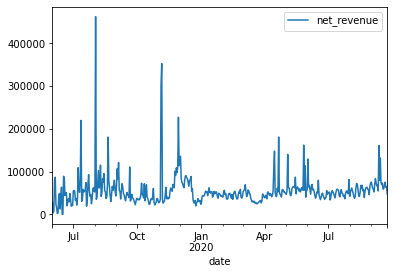

In [14]:
net_rev.plot()

In [100]:
non_stationary = ['T-Shirts', 'Football socks','Caps','Sweatshirts','Jackets','Other Equipment','Tracksuits','Guards','Socks','Training'] # all are group1 categories

In [30]:
# groups.plot()

In [15]:
groups = net_rev.groupby(pd.Grouper(freq='M'))


In [8]:
x = preprocess.select_series(data, group1='Socks')

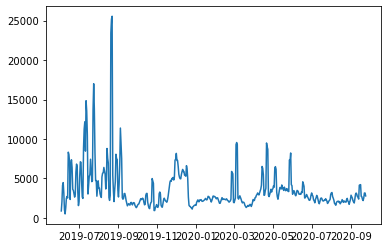

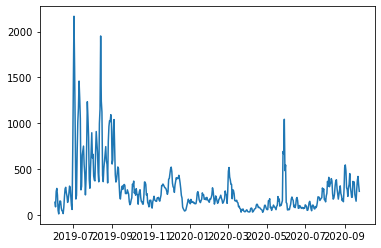

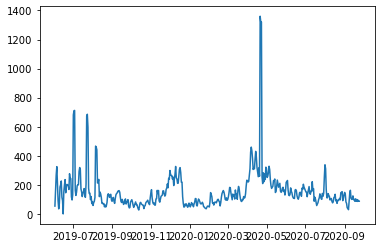

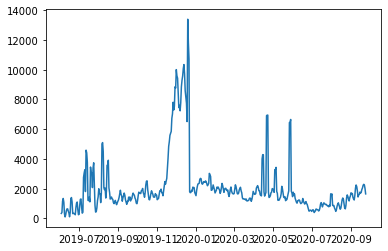

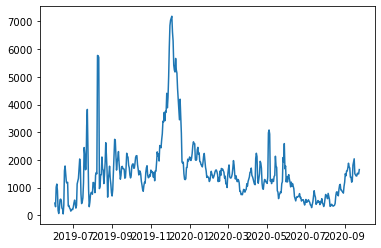

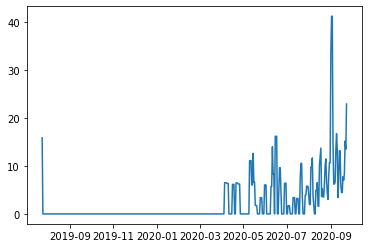

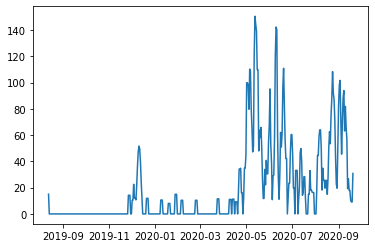

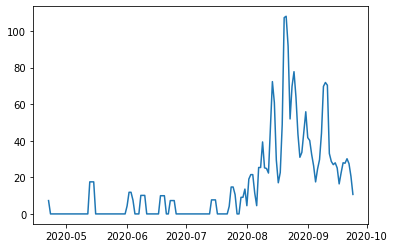

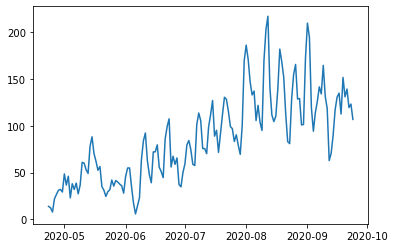

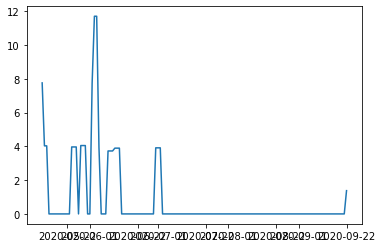

In [105]:
for category in non_stationary:
    net_rev = preprocess.select_series(data, group1=category)
    net_rev = net_rev.set_index('date')
    net_rev = net_rev.net_revenue.rolling(window=3).mean()
    plt.figure()
    plt.plot(net_rev)

&lt;AxesSubplot:xlabel=&#39;date&#39;&gt;

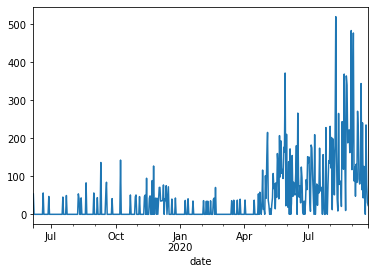

In [99]:
net_rev.net_revenue.plot()

&lt;AxesSubplot:&gt;

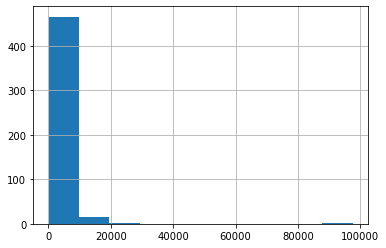

In [32]:
net_rev.net_revenue.hist()

&lt;AxesSubplot:ylabel=&#39;Density&#39;&gt;

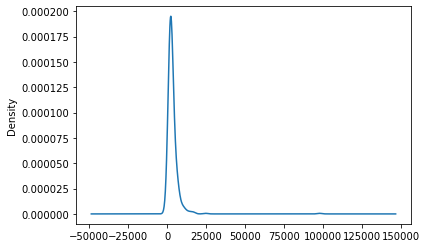

In [33]:
net_rev.net_revenue.plot(kind='kde')

In [34]:
# # groups.boxplot()
# ncols = 2
# nrows = int(np.ceil(groups.ngroups/ncols))
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,20), sharey=False)
# for (key, ax) in zip(groups.groups.keys(), axes.flatten()):
#     groups.get_group(key).boxplot(ax=ax)
# plt.show()

&lt;AxesSubplot:&gt;

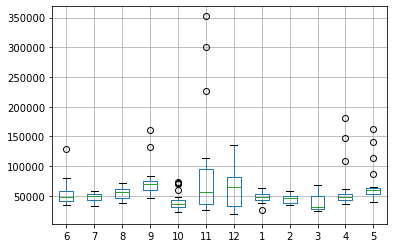

In [16]:
# Compare how the distributinos change month to month
months = pd.DataFrame()
# pd.concat([pd.Series(group.iloc[:,0]) for group in groups], axis=1)
for name, group in groups:
    months[name.month] = pd.Series(group.values.reshape(-1))
months.boxplot()


In [36]:
net_rev.net_revenue.describe()

count      482.000000
mean      3405.512714
std       5025.392894
min         76.214589
25%       1769.027983
50%       2417.939199
75%       3547.223608
max      97627.454260
Name: net_revenue, dtype: float64

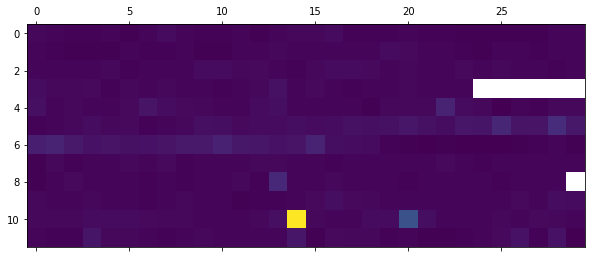

In [37]:
months = pd.DataFrame()
for name, group in groups:
    months[name.month] = pd.Series(group.values.reshape(-1))
months = months.T
plt.matshow(months, interpolation=None, aspect='auto')
plt.show()

&lt;AxesSubplot:xlabel=&#39;Lag&#39;, ylabel=&#39;Autocorrelation&#39;&gt;

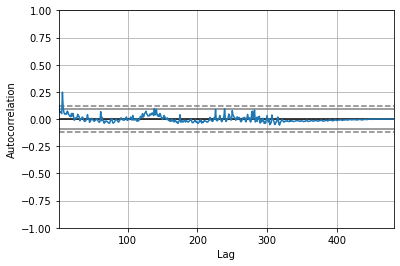

In [38]:
# Is this series of values correlated significantly with some past value for a given time interval/lag?
pd.plotting.autocorrelation_plot(net_rev.net_revenue)

&lt;AxesSubplot:xlabel=&#39;date&#39;&gt;

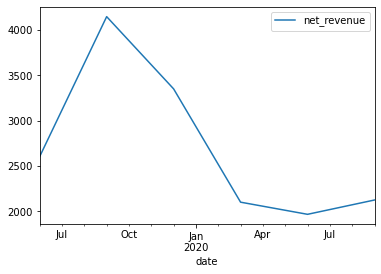

In [39]:
net_rev.resample('3M').median().plot()

&lt;AxesSubplot:xlabel=&#39;date&#39;&gt;

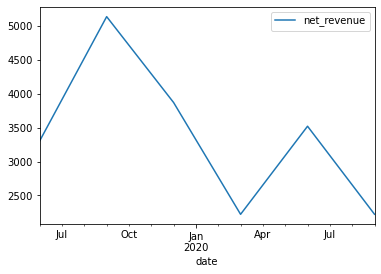

In [40]:
net_rev.resample('3M').mean().plot()

&lt;AxesSubplot:&gt;

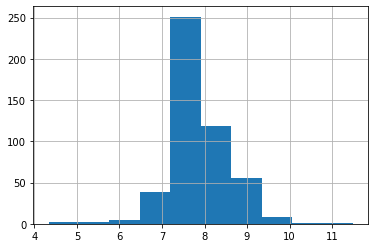

In [41]:
from scipy.stats import boxcox
net_rev['transformed'] = boxcox(net_rev.net_revenue, lmbda=0.0)
net_rev['transformed'].hist()

&lt;AxesSubplot:&gt;

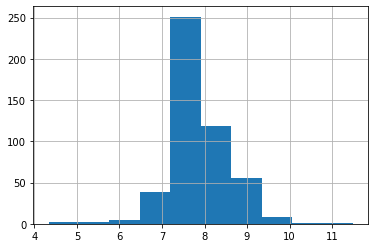

In [42]:
net_rev['transformed'].hist()

&lt;AxesSubplot:xlabel=&#39;date&#39;&gt;

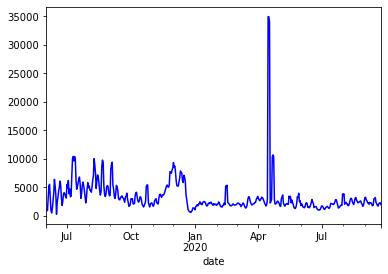

In [43]:
net_rev.net_revenue.rolling(window=3).mean().plot(color='blue')
# net_rev.net_revenue.plot(color='red')

In [44]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(net_rev.net_revenue)
print( ' ADF Statistic: %f ' % result[0])
print( ' p-value: %f ' % result[1])
print( ' Critical Values: ' )
for key, value in result[4].items():
    print( ' \t%s: %.3f ' % (key, value))
# test statistic less than critical values and p-value less than 0.05 implies data is stationary

 ADF Statistic: -6.080640 
 p-value: 0.000000 
 Critical Values: 
 	1%: -3.444 
 	5%: -2.868 
 	10%: -2.570 


In [45]:
# net_rev.to_csv('test_rev.csv')

In [21]:
from statsmodels.tsa.stattools import adfuller
x = data.site.unique()
x = [x for x in x if isinstance(x,str)]
for category in x:
    net_rev = preprocess.select_series(data, group1=category)
    net_rev = net_rev.set_index('date')
    result = adfuller(net_rev.net_revenue)
    print(f'{category} p-value: {result[1]:.4f}')


ValueError: sample size is too short to use selected regression component

In [3]:
sites = data.site.unique()
sites = [site for site in sites if isinstance(site,str)]
country_codes = {country for country in [site[-2:] for site in sites]}
grouped_sites = []
for code in country_codes:
    grouped_sites.append([site for site in sites if site[-2:] == code])

In [4]:
net_rev = preprocess.select_series(data, site=grouped_sites[1])

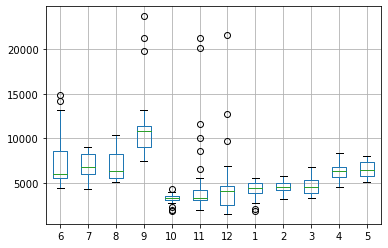

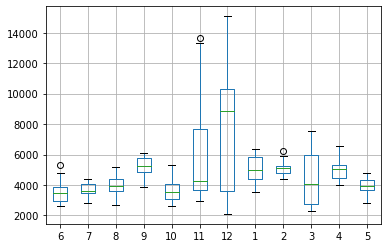

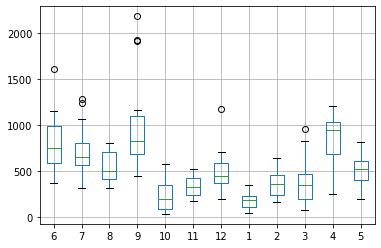

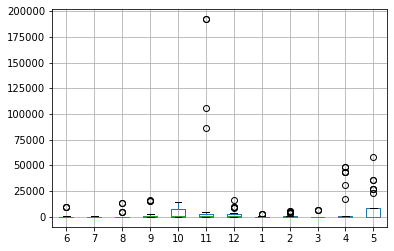

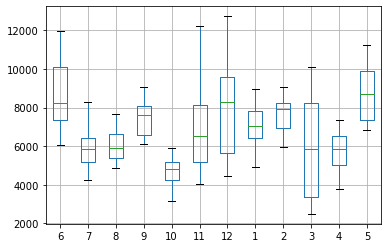

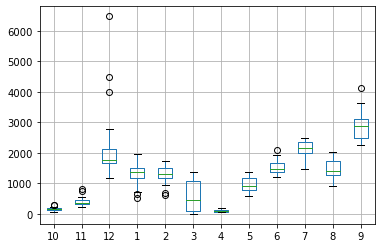

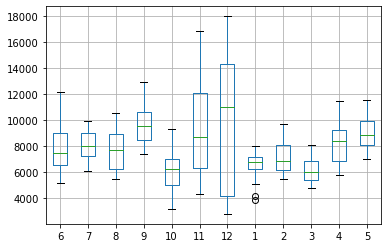

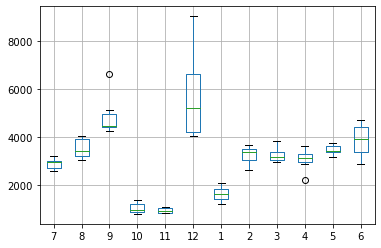

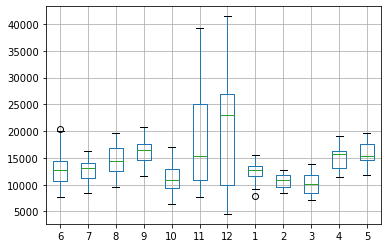

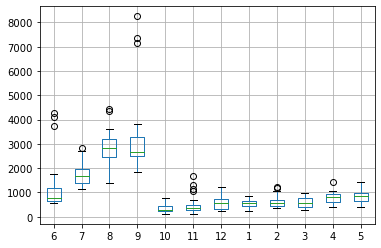

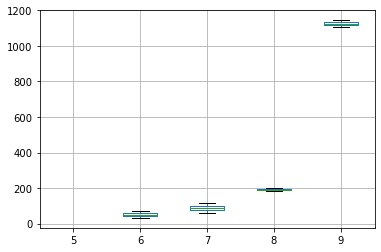

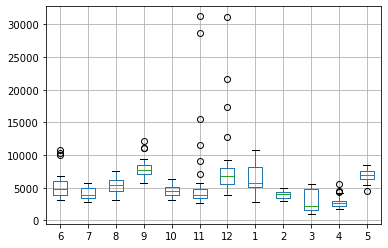

In [7]:
for sites_list in grouped_sites:
    net_rev = preprocess.select_series(data, site=sites_list)
    net_rev = net_rev.set_index('date')
    net_rev = net_rev.net_revenue.rolling(window=3).mean()
    groups = net_rev.groupby(pd.Grouper(freq='M'))
    months = pd.DataFrame()
    for name, group in groups:
        months[name.month] = pd.Series(group.values.reshape(-1))
    plt.figure()
    months.boxplot()

In [10]:
data.site.unique()

array([&#39;11teamsports.ro&#39;, &#39;Other&#39;, &#39;11teamsports.cz&#39;, &#39;11teamsports.hu&#39;,
       &#39;11teamsports.sk&#39;, &#39;top4football.fr&#39;, &#39;top4sport.cz&#39;,
       &#39;top4fitness.sk&#39;, &#39;top4running.hu&#39;, &#39;top4fitness.hu&#39;,
       &#39;top4running.cz&#39;, &#39;top4running.es&#39;, &#39;top4running.de&#39;,
       &#39;top4running.sk&#39;, &#39;top4running.hr&#39;, &#39;top4running.com&#39;,
       &#39;top4running.fr&#39;, &#39;top4fitness.es&#39;, &#39;top4street.cz&#39;,
       &#39;top4fitness.cz&#39;, &#39;top4street.sk&#39;, &#39;top4street.hu&#39;,
       &#39;top4running.ro&#39;, &#39;top4fitness.ro&#39;, &#39;top4street.ro&#39;,
       &#39;top4fitness.de&#39;, &#39;top4football.de&#39;, &#39;11teamsports.hr&#39;,
       &#39;top4football.com&#39;, &#39;top4fitness.com&#39;, &#39;top4fitness.hr&#39;,
       &#39;top4football.es&#39;, &#39;top4running.at&#39;, &#39;top4fitness.at&#39;,
       &#39;top4fitness.fr&#39;, &#39;top4

In [12]:
data.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
Int64Index: 798354 entries, 0 to 798353
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             798354 non-null  object        
 1   date                 798354 non-null  datetime64[ns]
 2   customer_code        798354 non-null  object        
 3   payment_id           795165 non-null  object        
 4   payment              795165 non-null  object        
 5   item_code            798354 non-null  object        
 6   quantity             798354 non-null  int64         
 7   unit_price_vat_excl  798354 non-null  float64       
 8   unit_cogs            798354 non-null  float64       
 9   unit_rrp_vat_excl    787560 non-null  float64       
 10  sales_person_id      797055 non-null  float64       
 11  sales_person         797055 non-null  object        
 12  department           798354 non-null  object        
 13  